In [34]:
import numpy as np
import os
import cv2  
import matplotlib.pyplot as plt 
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torchvision.transforms import Compose, Resize, Normalize, ToTensor
from torchvision import transforms

from itertools import islice
from torchvision.datasets import ImageFolder

# Import Data

In [3]:
"""
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

IMAGE_SIZE = (150, 150)

train_img = []
test_img = []

train_labels = []
test_labels = []


os.chdir('/Users/pavelshaburov/Desktop/ComputerVision/Image_Classification/archive/')

for folder in os.listdir():
    local_path = os.path.join(folder)
    #if os.path.basename(local_path) == "seg_train":
    for sub_folder in os.listdir(local_path):
        class_folder = os.path.join(local_path, sub_folder)
        if os.path.isdir(class_folder):
            for item in os.listdir(class_folder):
                image_path = os.path.join(class_folder, item)
                label = class_names_label[os.path.basename(class_folder)]
                
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                if os.path.basename(local_path) == "seg_train":
                    train_img.append(image)
                    train_labels.append(label)
                else:
                    test_img.append(image)
                    test_labels.append(label)
                           

                        
train_img = np.array(train_img)
train_img = (train_img/255.0)
train_img = np.transpose(train_img, (0, 3, 1, 2))
train_labels = np.array(train_labels,  dtype = 'int32')

test_img = np.array(test_img)
test_img = (test_img/255.0)
test_img = np.transpose(test_img, (0, 3, 1, 2))
test_labels = np.array(test_labels,  dtype = 'int32')   
"""


## Create Dataset

In [2]:
ImageFolder?

In [91]:
os.chdir('/Users/pavelshaburov/Desktop/ComputerVision/Image_Classification/archive/')

t = Compose([
    #Resize((150, 150)),
    Resize((227, 227)),
    ToTensor(),
    Normalize((0.5,), (0.5,)),
])

train_dataset = ImageFolder("./seg_train/", transform=t)
val_dataset = ImageFolder("./seg_test/", transform=t)

print(len(train_dataset))
print(len(val_dataset))

14034
3000


## Display Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1
AxesImage(54,36;334.8x217.44)


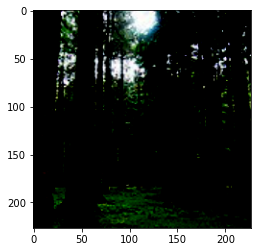

In [92]:
def display_images():
    k = random.randint(0, 10000)
    img = np.array(train_dataset[k][0])
    img = np.transpose(img, (1, 2, 0))
    print(train_dataset[k][1])
    print(plt.imshow(img))


display_images()

## Create Dataloader

In [93]:
trainloader = DataLoader(
    train_dataset,
    batch_size=31,
    shuffle=True,
    num_workers=4,
)

testloader = DataLoader(
    val_dataset,
    batch_size=32 ,
    shuffle=True,
    num_workers=4,
    drop_last=True
)

In [94]:
### check dataloader
batch = next(iter(trainloader))
images, labels = batch

print(images.shape)
print(labels.shape)

torch.Size([31, 3, 227, 227])
torch.Size([31])


## Building the Model:

In [102]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4),           # ( in_channels, out_channels, window_size, )
            nn.ReLU(),
            nn.MaxPool2d(3, stride = 2),                          # kernel size, stride
            nn.Conv2d(96, 256, kernel_size = 5, padding=2, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(3, stride = 2), 
            nn.Conv2d(256, 384, kernel_size = 3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size = 3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size = 3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(3, stride = 2),
        )
        self.fc_model = nn.Sequential(
            nn.Linear(9216, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 6)
        )
        

    def forward(self, X):
        # X.shape == (batch_size, 3, 227, 227)
        X = self.cnn_model(X)
        X = X.view(X.size(0), -1) 
        X = self.fc_model(X)  
        return X
            

In [103]:
net = AlexNet()

batch = next(iter(trainloader))
images, labels = batch

#print(images.shape, labels.shape)
    
logits = net(images)
print(logits.shape)
    

torch.Size([31, 6])


In [104]:
logits

tensor([[-0.0028, -0.0129, -0.0052,  0.0015, -0.0043, -0.0096],
        [-0.0032, -0.0125, -0.0059,  0.0005, -0.0036, -0.0091],
        [-0.0032, -0.0128, -0.0049,  0.0018, -0.0054, -0.0101],
        [-0.0029, -0.0118, -0.0058,  0.0020, -0.0052, -0.0093],
        [-0.0033, -0.0123, -0.0049,  0.0016, -0.0045, -0.0106],
        [-0.0034, -0.0127, -0.0052,  0.0014, -0.0048, -0.0106],
        [-0.0034, -0.0116, -0.0055,  0.0020, -0.0047, -0.0106],
        [-0.0032, -0.0126, -0.0055,  0.0019, -0.0045, -0.0098],
        [-0.0037, -0.0125, -0.0050,  0.0019, -0.0041, -0.0102],
        [-0.0029, -0.0129, -0.0048,  0.0014, -0.0051, -0.0107],
        [-0.0033, -0.0116, -0.0055,  0.0018, -0.0047, -0.0099],
        [-0.0025, -0.0121, -0.0057,  0.0014, -0.0040, -0.0092],
        [-0.0033, -0.0126, -0.0051,  0.0024, -0.0055, -0.0104],
        [-0.0031, -0.0130, -0.0053,  0.0017, -0.0046, -0.0096],
        [-0.0029, -0.0122, -0.0054,  0.0010, -0.0044, -0.0095],
        [-0.0032, -0.0126, -0.0051,  0.0